In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


In [25]:
df = pd.read_excel("pm10s_classes500m.xlsx")

X = df[["pm10_weighted", "Urbanizado", "Transporte"]] 
y = df["pm10"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [26]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000],
    'max_features': [1, 2, 3] 
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_root_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)


Best Parameters: {'max_features': 2, 'n_estimators': 1000}


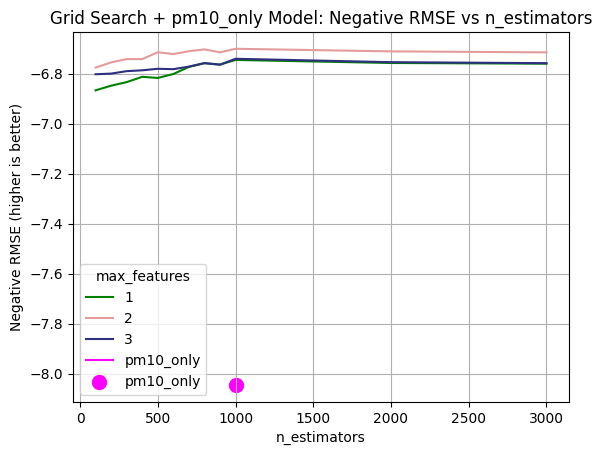

"You only have 50 samples, which is tiny.\n\n    If you let every tree use all 3 features at each split (max_features=3), you:\n\n        Build very similar trees\n\n        Increase overfitting risk\n\n    If you force each tree to pick from just 1 feature at a time (max_features=1):\n\n        Trees are more random and diverse\n\n        Ensemble benefits from this randomness and generalizes better\n\nThis is a classic bias-variance trade-off:\n\n    Less features → more bias per tree, but lower variance in the forest\n\n    And that's good for your small data situation."

In [32]:
results = pd.DataFrame(grid_search.cv_results_)[['param_n_estimators', 'param_max_features', 'mean_test_score']]

# 🔧 Add a separate model trained on only pm10_weighted
rf_pm10_only = RandomForestRegressor(n_estimators=1000, random_state=42)
rf_pm10_only.fit(X_train[['pm10_weighted']], y_train)
y_pred_pm10 = rf_pm10_only.predict(X_test[['pm10_weighted']])
mse_pm10 = mean_squared_error(y_test, y_pred_pm10)
rmse_pm10 = np.sqrt(mse_pm10)

neg_rmse_pm10 = -rmse_pm10

# Append it as a row for plotting
pm10_row = pd.DataFrame({
    'param_n_estimators': [1000],
    'param_max_features': ['pm10_only'],
    'mean_test_score': [neg_rmse_pm10]
})

results_plot = pd.concat([results, pm10_row], ignore_index=True)

# Convert for plotting
results_plot['param_max_features'] = results_plot['param_max_features'].astype(str)

# Custom color palette
palette = {
    '1': 'green',     
    '2': '#e49b9b',   
    '3': '#2f2f7f',
    'pm10_only': 'magenta'
}

# Plot
sns.lineplot(
    data=results_plot,
    x='param_n_estimators',
    y='mean_test_score',
    hue='param_max_features',
    palette=palette
)
# Add single-point scatter manually for pm10_only
pm10_point = results_plot[results_plot['param_max_features'] == 'pm10_only']
plt.scatter(
    pm10_point['param_n_estimators'],
    pm10_point['mean_test_score'],
    color='magenta',
    s=100,
    label='pm10_only'
)


plt.title("Grid Search + pm10_only Model: Negative RMSE vs n_estimators")
plt.ylabel("Negative RMSE (higher is better)")
plt.xlabel("n_estimators")
plt.grid(True)
plt.legend(title="max_features")
plt.show()

"""You only have 50 samples, which is tiny.

    If you let every tree use all 3 features at each split (max_features=3), you:

        Build very similar trees

        Increase overfitting risk

    If you force each tree to pick from just 1 feature at a time (max_features=1):

        Trees are more random and diverse

        Ensemble benefits from this randomness and generalizes better

This is a classic bias-variance trade-off:

    Less features → more bias per tree, but lower variance in the forest

    And that's good for your small data situation."""




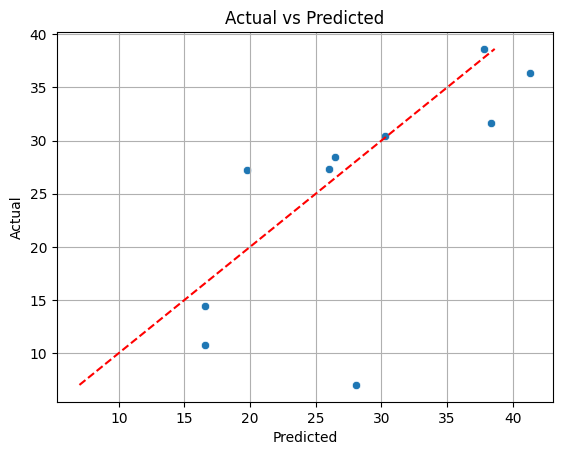

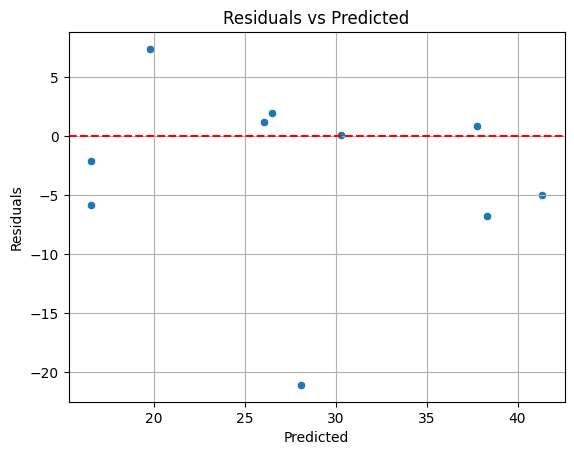

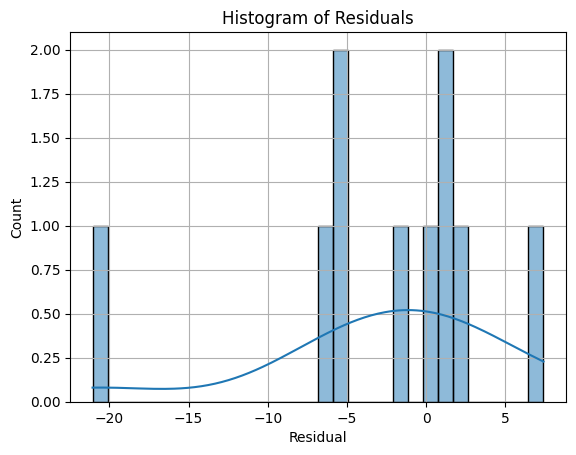

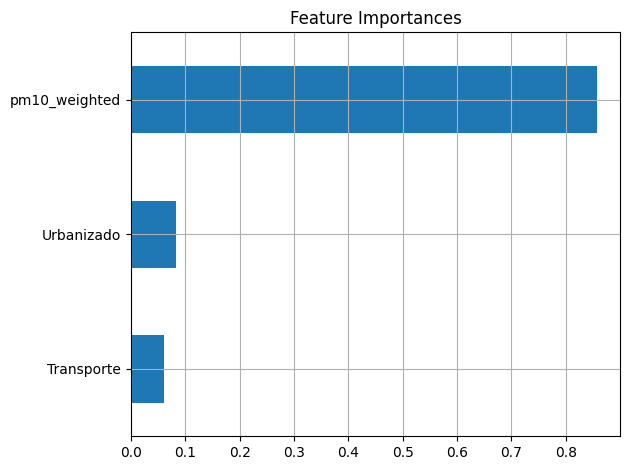

In [29]:
plt.figure()
sns.scatterplot(x=y_pred, y=y_test)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Actual vs Predicted")
plt.grid(True)
plt.show()

plt.figure()
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.grid(True)
plt.show()

plt.figure()
sns.histplot(residuals, bins=30, kde=True)
plt.title("Histogram of Residuals")
plt.xlabel("Residual")
plt.grid(True)
plt.show()

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values(ascending=True).plot(kind='barh', title="Feature Importances")
plt.grid(True)
plt.tight_layout()
plt.show()


In [30]:
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}, R²: {r2:.2f}")

RMSE: 7.83, R²: 0.41
